# # Intro To Tensorflow # 4

# by PARK-SI HYUNG. 2019-01-23
---
> Gererative adversarial network, 생성적 적대 신경망

> 발음하기도 힘든 생성적 적대 신경망, 한번 알아봅시다

![JPEG](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1524648806/gan_network_eg_jcgooq.jpg)
#   
# WHAT IS GAN?
> 진짜 같은 가짜를 만들어내는 프레임워크

- GAN은 '생성적 적대 신경망'이라는 이름처럼 두 신경망 모델의 경쟁을 통해 학습하고 
- 결과물을 만들어 냅니다
- 인간이 정답을 알려주지 않아도 경쟁 과정 속에 스스로 학습합니다

#   
# GENERATOR(생성자)

> 위조 지폐범같은 역할을  합니다

![JPEG](https://www.bloter.net/wp-content/uploads/2018/06/GANsplain_1-800x403.jpg)

#### 생성자는 노이즈로부터 결과물을 만들어 냅니다
#   
# DISCRIMINATOR(감별자)

> 경찰의 역할을 합니다

#### 감별자는 실제 DATASET 훈련을 통해 생성자가 내놓은 결과물이 진짜인지 구별합니다

- 생성자의 거짓 데이터에 놀아나지 않는 게 목적입니다
- 생성자는 감별자를 속이지 못한 데이터를 학습하고
- 감별자는 생성자에게 속은 데이터를 입력받아 학습합니다
#   

# HOW IT WORKS?

![JPEG](https://2.bp.blogspot.com/-2AA2ws2s6xc/WHjzFO5zBbI/AAAAAAAABKw/g91OEkkxPHYKPTsfKYC5yzXn3CmH6gi_ACK4B/s400/%25EA%25B7%25B8%25EB%25A6%25BC6.PNG)

> 왼쪽이 감별자(실제 데이터를 가지고 판별), 오른쪽이 생성자 입니다

- 생성자는 초기에 랜덤하게 이미지를 생성합니다
- 감별자는 ACTUAL DATASET과 생성자가 만들어낸 이미지를 비교합니다
- 감별자는 0과1 사이의 확률을 알려줍니다. 1일수록 진짜, 0일수록 가짜
- 생성자와 감별자가 결합한 LOSS를 생성자에게 BACKPROP해줍니다
- 생성자는 감별자가 실수할 확률을 높이기 위해 노력하고, 감별자는 실수할 확률을 줄이려 합니다
- 학습이 진행됨에 따라 최종적으로 감별자는 더이상 분류를 해도 의미가 없는 0.5를 반합니다
- 마치 동전의 앞면이 나올 확률이 0.5인것처럼 말이죠

#    
# GAN의 확률분포적 특성

- GAN에서 다루고자 하는 모든 데이터는 확률분포를 가지고 있는 랜덤변수 입니다
- 확률분포를 알면 예측 기댓값 등 데이터의 통계적 특성을 바로 분석할 수 있습니다
- 주어진 확률분포를 따르도록 데이터를 임의 생성하면 원 데이터와 유사한 값을 가집니다
- GAN처럼 데이터에 대한 확률분포를 모델링 할 수 있게 되면, 원 데이터와 확률분포를
- 정확히 공유하는 무한히 많은 데이터를 새로 생성할 수 있습니다

---
#### 생성자는 원 데이터의 확률분포를 알아내려 노력하고 분포를 재현하여 실 데이터와 
#### 차이가 없도록 하고, 판별자는 판별 대상인 데이터가 실 데이터인지 생성자가 만들어낸 
#### 데이터인지 각각에 대한 확률을 추정합니다
---
#   

![JPEG](https://i.imgur.com/gLQPRCj.png)

#   
- 처음 시작할 때는 파란색(감별자)와 초록색(생성자)이 전혀 다른것을 알 수 있습니다 (당연히)
- 감별자가 실제 데이터와 생성자를 구분하기 위해 학습을 해서 살짝 SMOOTH해집니다
- 이후 생성자가 현재 감별자가 구별하기 어려운 방향으로 학습을 하면 (C)처럼 가까워집니다
#### 최종적으로 감별자는 더이상 의미가 없는 0.5라는 확률을 뱉어냅니다
 
#   
# GAN Tutorial # 1
#   

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/VGAN/MNIST'

# mnist data를 가져옵니다
def mnist_data():
    # 텐서 형식으로 변환합니다
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)


# Load Data

In [2]:
# data 불러옵니다
data = mnist_data()
# 재사용할 수 있도록 loader를 생성합니다
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# batch 사이즈
num_batches = len(data_loader)

# Discriminator(식별자)

In [3]:
# 3 HIDDEN LAYER를 가진 DISCRIMINATOR 정의합니다
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        
        # 맨처음 input은 784개
        # 마지막 output은 1개
        n_features = 784
        n_out = 1
        
        # 3개의 hidden layer 층
        # 처음 INPUT 784, OUTPUT 1024
        # 활성화함수로 LeakyReLU를 사용하고
        # 오버피팅 방지를 위해 dropout합니다
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
        
        # foward 함수를 정의합니다
        
        def forward(self, x):
            x = self.hidden0(x)
            x = self.hidden1(x)
            x = self.out(x)
            return x
        
# 이미지를 벡터형태로 바꿔줍니다
def images_to_vectors(images):
    return images.view(images.size(0), 784)

# 벡터를 이미지로 바꿔줍니다
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Generator(생성자)

In [4]:
# 3개의 hidden layer를 가진 generator를 정의합니다
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        # 처음 input은 100
        # 마지막 output은 784
        n_features = 100
        n_out = 784
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
    # forward 함수를 정의합니다
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# generator는 이미지를 생성하기 위해 무작위의 noise가 필요합니다
# 랜덤함수를 통해 노이즈를 생성합니다
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [5]:
# discriminator와 generator 객체를 생성합니다
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

# Optimization

In [14]:
# discriminator와 generator의 optimizer를 정해줍니다
# Adam optimizer를 사용합니다
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# loss function을 설정합니다
# 서로의 확률을 결합한 값을 loss로 사용해야하니
# BCE(BINARY CROSS ENTROPY)를 사용합니다
loss = nn.BCELoss()

d_steps = 1
num_epochs = 10

# Training

In [15]:
# 진짜일 확률을 모두 1로 초기화합니다
def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data
# 가짜일 확률을 모두 0으로 초기화합니다
def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data    

In [19]:
# discriminator를 generator가 만든 가짜 이미지와 진짜 이미지랑 비교해 훈련시킵니다
def train_discriminator(optimizer, real_data, fake_data):
    # gradient를 초기화합니다
    optimizer.zero_grad()
    
    # 먼저 진짜 이미지로 훈련시킵니다
    prediction_real = discriminator(real_data)
    # loss를 계산하고 backprop 시킵니다
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()
    
    # 그다음 generator가 만든 가짜이미지로 훈련시킵니다
    prediction_fake = discriminator(fake_data)
    # loss를 계산하고 backprop 시킵니다
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # gradient로 weight를 update 시킵니다
    optimizer.step()
    
    # 진짜 이미지의 error와 가짜 이미지의 error를 합해 loss를 반환합니다
    
    return error_real + error_fake, prediction_real, prediction_fake

# generator를 가짜 이미지를 통해 훈련시킵니다
def train_generator(optimizer, fake_data):
    # gradient를 초기화합니다
    optimizer.zero_grad()
    # noise로부터 무작위로 fake data를 만듭니다
    prediction = discriminator(fake_data)
    # loss를 계산하고 backprop시킵니다
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # gradient로 weight를 update 시킵니다
    optimizer.step()
    # error를 반환합니다
    return error

# Generate Samples for Testing

In [20]:
# 16개만 실험해봅니다
num_test_samples = 16
test_noise = noise(num_test_samples)

# Start training

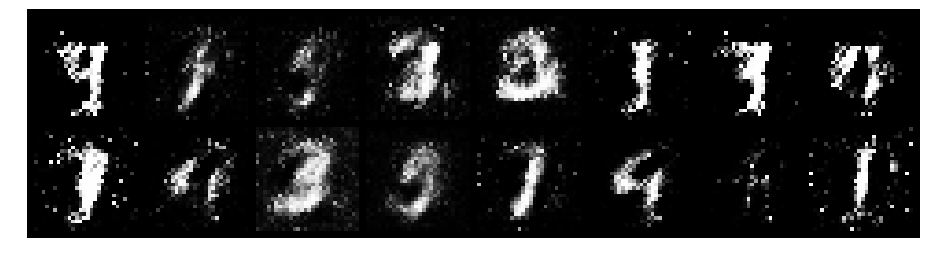

Epoch: [9/10], Batch Num: [500/600]
Discriminator Loss: 0.8391, Generator Loss: 1.5635
D(x): 0.7809, D(G(z)): 0.2643


In [21]:
logger = Logger(model_name='VGAN', data_name='MNIST')

# 정해진 횟수만큼 훈련시킵니다
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        # discriminator를 먼저 훈련시킵니다
        # 진짜 이미지를 벡터로 바꿉니다
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # generator가 fake 이미지를 만듭니다
        fake_data = generator(noise(real_data.size(0))).detach()
        # 진짜 이미지와 가짜 이미지의 loss를 통해 훈련시킵니다
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        # 그 다음 generator를 훈련시킵니다
        # noise를 사용해 fake 이미지를 만듭니다
        fake_data = generator(noise(real_batch.size(0)))
        # generator를 가짜 이미지를 이용해 훈련시킵니다
        g_error = train_generator(g_optimizer, fake_data)
        # 결과를 살펴보기 위해 log에 입력합니다
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # 100번마다 결과를 출력합니다
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

#  
# GAN Tutorial # 2
#     

In [9]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

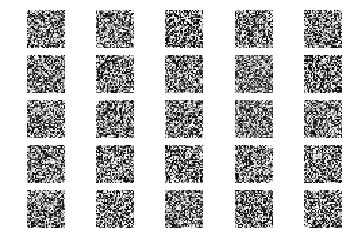

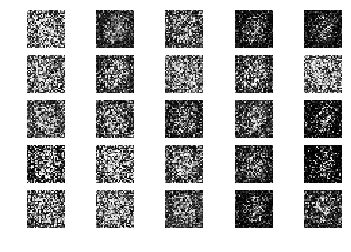

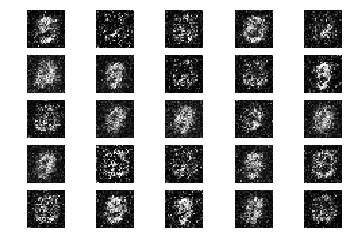

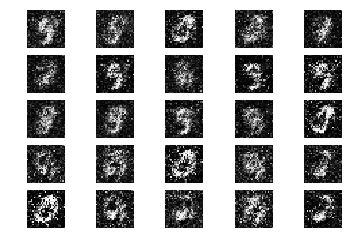

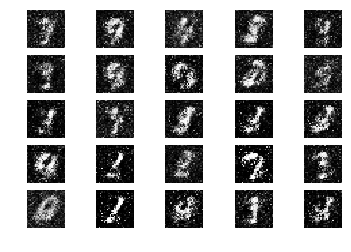

In [11]:
# GAN 클래스를 정의해봅니다
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        # 원래는 3채널의 IMAGE이지만 1채널로 바꿔서 넣어줍니다
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # 최적화로 Adam optimizer를 사용합니다
        # Adam optimizer는 gradient과 squared gradient의 평균을 사용합니다
        # learning rate 0.0002, beta1은 0.5
        # beta1은 첫번째 훈련에서 얼마나 기하급수적으로 떨어뜨릴지를 정합니다
        optimizer = Adam(0.0002, 0.5)
        
        # discriminator(감별자)를 정의합니다
        self.discriminator = self.build_discriminator()
        # loss function은 cross_entropy, optimizer는 위에서 정한 Adam
        self.discriminator.compile(loss='binary_crossentropy',
                                optimizer=optimizer,
                                metrics=['accuracy'])
        
        # generator(생성자)를 정의합니다
        self.generator = self.build_generator()
        
        # generator는 noise를 통해 이미지를 생성합니다
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        # discriminator는 generator가 생성한 이미지를 가지고 판별합니다
        validity = self.discriminator(img)
        
        # 둘이 결합된 확률을 가지고 generator를 학습시킵니다
        # generator는 discriminator를 속이기 위해 훈련됩니다
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    # generator를 생성하는 함수를 정의합니다
    def build_generator(self):
        
        model = Sequential()
        
        # fully connected layer를 사용합니다
        # 활성화 함수로 ReLU를 사용합니다
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        # 우리가 만든 모델정보를 출력해서 보여줍니다
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        # keras의 Model 모듈을 이용해 Model을 반환합니다
        return Model(noise, img)
    
    # discriminator를 생성하는 함수를 정의합니다
    def build_discriminator(self):
        
        model = Sequential()
        
        # input받은 이미지를 1차원 배열로 납작하게 바꿔줍니다
        # 32X32 라면 1차원의 1024로 전환
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        # 우리가 만든 모델 정보를 출력해줍니다
        model.summary()

        img = Input(shape=self.img_shape)
        # 진짜인지 가짜인지 구분을 합니다
        validity = model(img)
        
        
        return Model(img, validity)

    # 훈련을 시킵니다
    def train(self, epochs, batch_size=128, sample_interval=50):
        # dataset을 가져옵니다
        (X_train, _), (_, _) = mnist.load_data()
        
        # -1 ~ 1 사이로 재조정합니다
        
        X_train = X_train / 127.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        
        # 진짜, 가짜 확률을 초기화합니다(진짜는 1, 가짜는 0)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # epoch 횟수만큼 훈련합니다
        for epoch in range(epochs):
            
            # ---------------------------
            # discriminator를 훈련시키는 과정
            # ---------------------------
            
            # 실제 이미지를 고릅니다 
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # generator가 선택할 noise를 고릅니다
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # 위의 noise를 가지고 generator가 이미지를 만듭니다
            gen_imgs = self.generator.predict(noise)
            
            
            # discriminator를 훈련시킵니다
            # 실제 이미지와 valid를 비교합니다
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            # generator가 만든 가짜 이미지와 fake를비교합니다
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            # 둘을 결합해 loss를 생성합니다
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            
            # ------------------------
            # Generator를 훈련시키는 과정
            # -----------------------
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            # generator를 훈련시킵니다
            # discriminator가 혼동할 정도로
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # 500번 마다 진행상황을 출력합니다
            
            if epoch % 500 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # 일정 훈련횟수가 넘으면 generator가 만든 이미지를 저장합니다
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
    
    # 실제로 만든 그림을 출력해봅니다
    def sample_images(self, epoch): 
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # 0 ~ 1 사이로 재조정합니다
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig('images/%d.png' % epoch)

        
# 훈련을 3만번 시켜봅니다
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=1000, batch_size=32, sample_interval=200)